#### This notebook is meant to introduce you to some of the concepts of machine learning using a simple data set and basic ML functions

First, load the required libraries

In this example, we use LightGBM and XGBoost to train the model on the Iris data set (loaded from Scikit-Learn) and test it's predictive abilities

In [1]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import normalize, label_binarize, StandardScaler

import IPython.core.display

2025-10-11 17:25:15.927325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this data set:
There is a column of truth values. This is called the target or label.
There are columns of data called features, variables or predictors.

The model will be trained to predict the truth based on the features.

In [2]:
# We'll use the classic Iris dataset for this example.
iris = datasets.load_iris(as_frame=True)

# as_frame=True loads as a pandas dataframe and therefore is easier to work with
X = iris.data
y = iris.target

Let's explore this dataset a bit.

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [6]:
X.describe

<bound method NDFrame.describe of      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]>

In [7]:
y.describe

<bound method NDFrame.describe of 0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64>

#### Scatterplot to visualize the distribution of data

In [8]:
# let's create a cleaner dataframe to plot
iris_df = pd.DataFrame(data=iris.data)

# add the target to the data frame
iris_df['species'] = iris.target

# map target numerical values to species names
iris_df['species_name'] = iris_df['species'].map({i: name for i, name in enumerate(iris.target_names)})

In [9]:
# check the top and bottom of this new dataset
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [10]:
iris_df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica
149,5.9,3.0,5.1,1.8,2,virginica


Seaborn's pairplot creates a nice plot for us!

<Figure size 500x500 with 0 Axes>

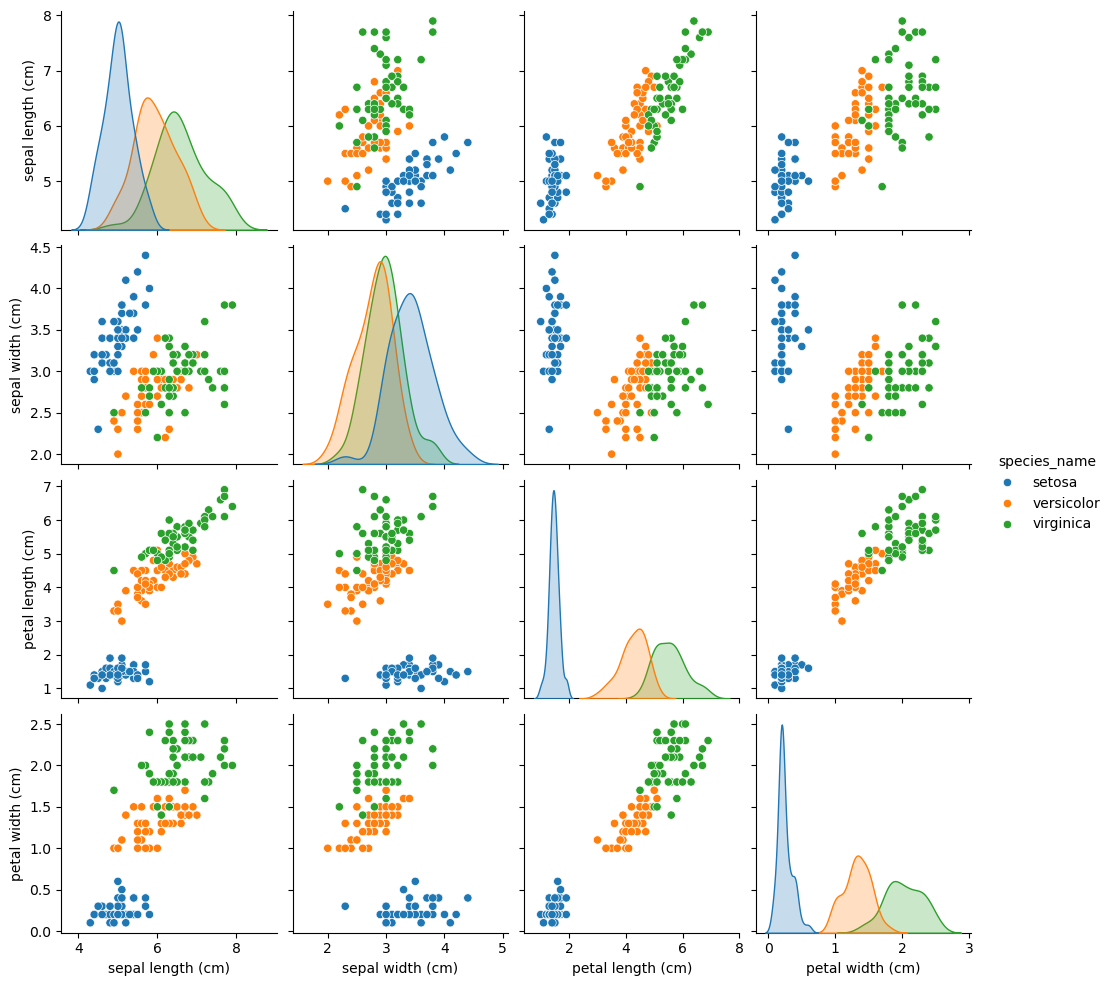

In [11]:
plt.figure(figsize=(5,5))
sns.pairplot(iris_df.drop('species', axis=1),hue='species_name')
plt.show()

We see that the data is already quite well separated. We expect our model(s) to do fairly well in this example.

#### Let's move on to the ML parts now

We split the data - both the features and the label data into train and test sets using the line below. Here, the split is 80-20%

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# What does train test split do?
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
22,4.6,3.6,1.0,0.2
15,5.7,4.4,1.5,0.4
65,6.7,3.1,4.4,1.4
11,4.8,3.4,1.6,0.2
42,4.4,3.2,1.3,0.2


In [14]:
X_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
73,6.1,2.8,4.7,1.2
18,5.7,3.8,1.7,0.3
118,7.7,2.6,6.9,2.3
78,6.0,2.9,4.5,1.5
76,6.8,2.8,4.8,1.4


In [15]:
y_train.head()

22    0
15    0
65    1
11    0
42    0
Name: target, dtype: int64

In [16]:
y_test.head()

73     1
18     0
118    2
78     1
76     1
Name: target, dtype: int64

The test and train data sets are each split into two subsets from the original X and y that contained the data.

#### Using the XGBoost classifier

In [17]:
# Initialize the XGBoost Classifier
# We use 'XGBClassifier' for classification tasks.
# 'objective' specifies the loss function; 'multi:softprob' is for multi-class classification.
# 'num_class' must be set to the number of unique classes in the target variable.
model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(iris.target_names), eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print('')

# You can also inspect feature importances
print("Feature Importances:")
for i, importance in enumerate(model.feature_importances_):
    print(f"Feature {i}: {importance:.4f}")

Accuracy: 1.00

Feature Importances:
Feature 0: 0.0111
Feature 1: 0.0290
Feature 2: 0.7525
Feature 3: 0.2074


__Feature importance plot__

In [18]:
# create the feature and importance dataframes for plotting
labels_df = pd.DataFrame(model.feature_names_in_,columns=['feature'])
importances_df = pd.DataFrame(model.feature_importances_,columns=['importance'])

# Combine the two DataFrames
combined_df = pd.concat([labels_df, importances_df], axis=1)

# Sort the data by importance metric
combined_df = combined_df.sort_values(by='importance', ascending=False)

# check the dataframes
# print(labels_df)
# print(importances_df)

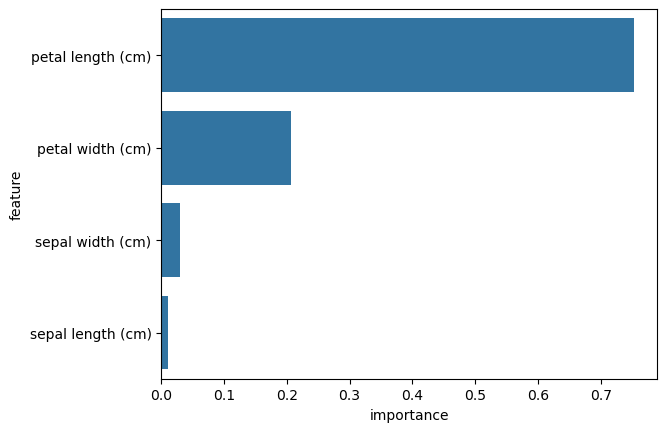

In [19]:
# let's plot the feature importances as well
sns.barplot(x='importance', y='feature', data=combined_df)
plt.show()


Petal length appears to be an important feature for classification purposes

#### LightGBM

Instead of a Scikit-learn API, we use the lightgbm core API 

In [20]:
# Initialize the LightGBM Core API

# define the parameters
params = {
          "objective" : "multiclass",
          "num_class" : len(iris.target_names),
          "num_leaves" : 6,
          "max_depth": 5,
          "learning_rate" : 0.01
}
    
# 'objective' specifies the loss function; 'multiclass' is for multi-class classification.
# 'num_class' must be set to the number of unique classes in the target variable.

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the LightGBM model
num_round = 20  # Number of boosting rounds
gbm = lgb.train(params,
                train_data,
                num_round,
                valid_sets=[test_data],
                callbacks=[lgb.early_stopping(10)]) # Early stopping if no improvement for 10 rounds

# Make predictions
y_pred_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = y_pred_proba.argmax(axis=1)  # Get the class with the highest probability

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=iris.target_names)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", report)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.073920
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

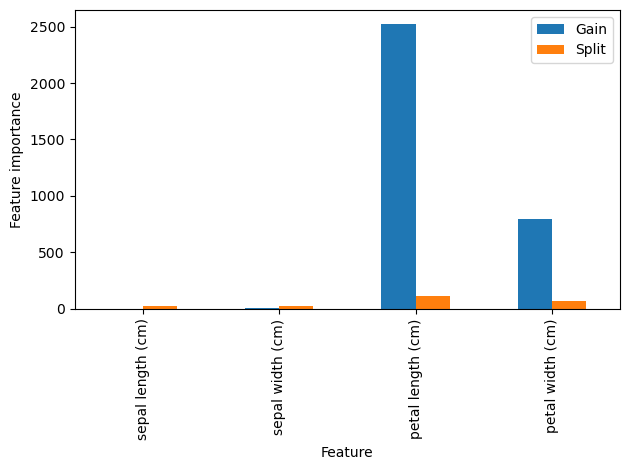

In [21]:
# plot the feature importances again
features = gbm.feature_name()

# feature importance by gain
importance_g = gbm.feature_importance(importance_type='gain')

# feature importance by split
importance_s = gbm.feature_importance(importance_type='split')

# create importance df
dat = {'Gain': importance_g, 'Split': importance_s, 'Feature': X.columns}

i_df = pd.DataFrame(dat)
i_df.head()

# plot
i_df.plot(x='Feature',y=['Gain','Split'], kind='bar')
plt.ylabel('Feature importance')
plt.legend()
plt.tight_layout()

#### Neural Network Classifier

In [22]:
print("Describing the data: ",iris.data.describe())
print("Info of the data:",iris.data.info())

Describing the data:         sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  -

In [23]:
# pre-processing for Neural Network classification
X_normalized=normalize(X,axis=0)
print("Examples of X_normalised\n",X_normalized[:4])

Examples of X_normalised
 [[0.07056264 0.09254209 0.02754801 0.01150242]
 [0.06779548 0.07932179 0.02754801 0.01150242]
 [0.06502832 0.08460991 0.02558029 0.01150242]
 [0.06364474 0.08196585 0.02951572 0.01150242]]


In [24]:
# use train test data set from above
print("Length of train set x:",X_train.shape[0],"y:",y_train.shape[0])
print("Length of test set x:",X_test.shape[0],"y:",y_test.shape[0])

Length of train set x: 120 y: 120
Length of test set x: 30 y: 30


In [25]:
"""
Preprocessing:
StandardScaler normalizes the feature data to have zero mean and unit variance, which can improve neural network performance.
keras.utils.to_categorical converts the integer target labels into a one-hot encoded format, suitable for multi-class classification with a softmax output layer.
"""

# Preprocessing: Scale features and One-Hot Encode target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable (species)
y_one_hot = keras.utils.to_categorical(y, num_classes=3)

# Redoing this even though the data was split before. Here the X values are scaled and y are also adapted.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42)

# Build the Neural Network Model
model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 4 features
    layers.Dense(10, activation='relu'),  # Hidden layer
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])

# A keras.Sequential model is created with:

# An input Dense layer with relu activation and input_shape matching the number of features.
# A hidden Dense layer with relu activation.
# An output Dense layer with softmax activation, which is standard for multi-class classification, outputting probabilities for each class.

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# The model is compiled with:

# optimizer='adam': An efficient optimization algorithm.
# loss='categorical_crossentropy': loss function for multi-class classification with one-hot encoded labels.
# metrics=['accuracy']: To monitor the accuracy during training and evaluation.

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split=0.1)

# model.fit() trains the network on the training data for a specified number of epochs (iterations over the entire dataset) and batch_size. 
# validation_split reserves a portion of the training data for validation during training.

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50


/home/dsigdel/miniconda3/envs/ML2025/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-11 17:25:20.339030: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3148 - loss: 1.1175 - val_accuracy: 0.4167 - val_loss: 1.0314
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3426 - loss: 1.0449 - val_accuracy: 0.4167 - val_loss: 0.9847
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3704 - loss: 0.9882 - val_accuracy: 0.4167 - val_loss: 0.9400
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4167 - loss: 0.9429 - val_accuracy: 0.5000 - val_loss: 0.9034
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 0.9043 - val_accuracy: 0.5000 - val_loss: 0.8755
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5648 - loss: 0.8718 - val_accuracy: 0.6667 - val_loss: 0.8509
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5926 - loss: 0.8393 - val_accuracy: 0.6667 - val_loss: 0.8301
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6111 - loss: 0.8068 - val_accuracy: 0.6667 - val_loss: 0.8091
Ep

Test accuracy reaches 1.0 for both Boosted tree methods, and the Neural network method. We made an educated guess that classifying data here might be easier since data seemed well separated even by naked eye.

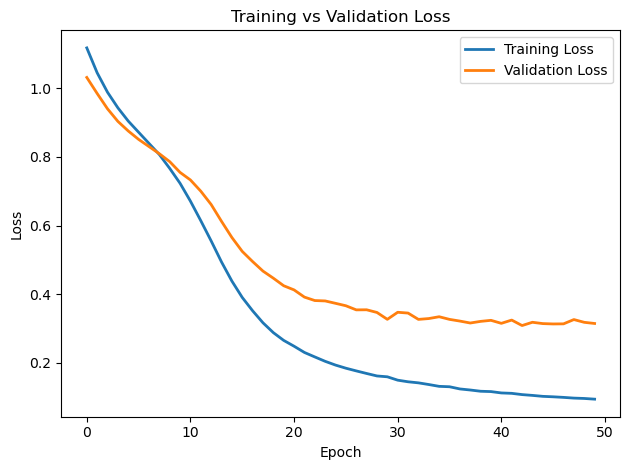

In [26]:
# let's plot the training & validation loss values
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


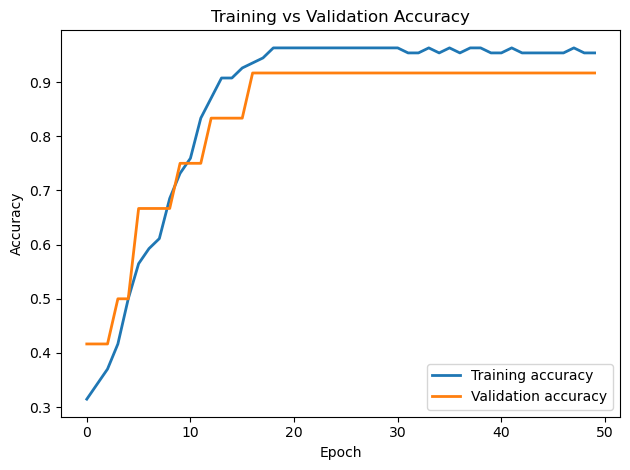

In [27]:
# let's plot the accuracies
plt.plot(history.history['accuracy'], label='Training accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()